In [29]:
import pandas as pd


gdp_data = pd.read_csv('imf_gdp_capita.csv').rename(columns={'GDP per capita, current prices\n (U.S. dollars per capita)':'Country'})
gdp_data = gdp_data[gdp_data["Country"] == "Kenya"]

gdp_data = pd.melt(gdp_data, id_vars=['Country'], var_name='Year', value_name='GDP_per_capita')
gdp_data['Year'] = pd.to_numeric(gdp_data['Year'])
gdp_data['GDP_per_capita'] = pd.to_numeric(gdp_data['GDP_per_capita'])

el_access_data = pd.read_csv('share-of-the-population-with-access-to-electricity.csv').rename(columns={'Entity':'Country', 'Access to electricity (% of population)':'electricity_access'})
el_access_data = el_access_data[el_access_data["Country"] == "Kenya"]


electricity_data = pd.read_csv('share-elec-by-source.csv').rename(columns={'Entity':'Country'})
electricity_data = electricity_data[electricity_data["Country"] == "Kenya"]

renewable_columns = ['Hydro - % electricity', 'Solar - % electricity', 
                     'Wind - % electricity', 'Other renewables excluding bioenergy - % electricity']
non_renewable_columns = ['Coal - % electricity', 'Gas - % electricity', 
                         'Oil - % electricity', 'Nuclear - % electricity']

electricity_data['Renewable'] = electricity_data[renewable_columns].sum(axis=1)
electricity_data['Non-renewable'] = electricity_data[non_renewable_columns].sum(axis=1)


In [52]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Merge data on the Year column
merged_data = pd.merge(gdp_data, el_access_data[['Year', 'electricity_access']], on='Year', how='left')
merged_data = pd.merge(merged_data, electricity_data[['Year', 'Renewable']], on='Year', how='left')

# Calculate year-on-year GDP growth
merged_data['GDP_growth'] = merged_data['GDP_per_capita'].pct_change() * 100  # Percentage change

# Drop NaN values that might have been generated by pct_change
merged_data.dropna(subset=['electricity_access', 'Renewable', 'GDP_growth'], inplace=True)


# Step 1: Correlation analysis (now with GDP growth included)
correlation = merged_data[['electricity_access', 'Renewable', 'GDP_growth']].corr()
print("Pearson Correlation with GDP Growth:")
print(correlation)

# Step 2: Regression analysis (with GDP growth as a control)
X = merged_data[['electricity_access', 'GDP_growth']]  # Include GDP growth as a predictor
y = merged_data['Renewable']

# Add constant for intercept
X = sm.add_constant(X)

# Run the regression model
model = sm.OLS(y, X).fit()

# Print regression results
print("\nRegression Results with GDP Growth as Control:")
print(model.summary())

Pearson Correlation with GDP Growth:
                    electricity_access  Renewable  GDP_growth
electricity_access            1.000000   0.834904    0.048234
Renewable                     0.834904   1.000000    0.124918
GDP_growth                    0.048234   0.124918    1.000000

Regression Results with GDP Growth as Control:
                            OLS Regression Results                            
Dep. Variable:              Renewable   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     22.62
Date:                Sun, 17 Nov 2024   Prob (F-statistic):           9.42e-06
Time:                        21:29:20   Log-Likelihood:                -73.771
No. Observations:                  22   AIC:                             153.5
Df Residuals:                      19   BIC:                             156.8
Df Model:                          

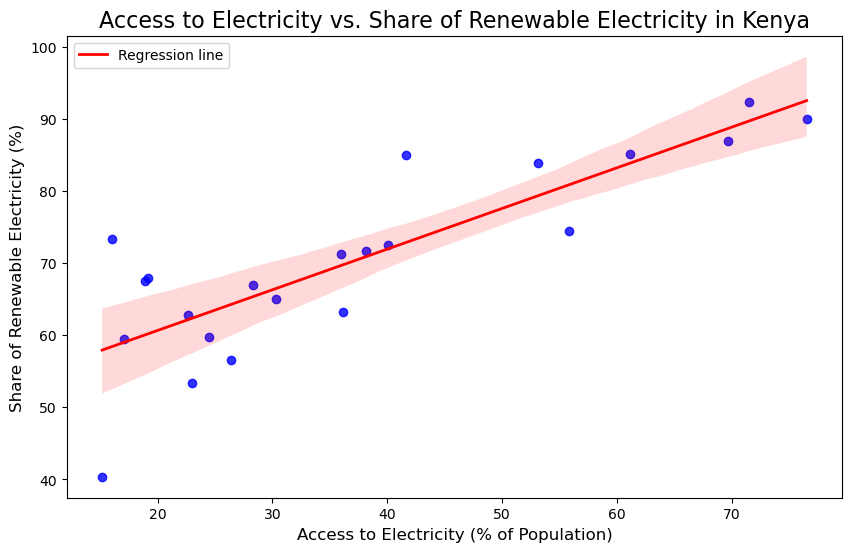

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot scatter plot with regression line
plt.figure(figsize=(10, 6))

sns.regplot(
    x='electricity_access', y='Renewable', data=merged_data, 
    scatter_kws={'color': 'blue', 'label': 'Data points'}, 
    line_kws={'color': 'red', 'linewidth': 2, 'label': 'Regression line'}
)

# Add titles and labels
plt.title('Access to Electricity vs. Share of Renewable Electricity in Kenya', fontsize=16)
plt.xlabel('Access to Electricity (% of Population)', fontsize=12)
plt.ylabel('Share of Renewable Electricity (%)', fontsize=12)


# Add the legend
plt.legend()

plt.savefig('regression.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


In [47]:
print(merged_data.drop(['Country'], axis=1).rename(columns={'GDP_per_capita':'GDP per capita', 'electricity_access':'Population percentage with access to electricity', 'GDP_growth':'GDP growth rate', 'Renewable':'Share of electricity produced from renewable sources'}).to_latex(index=False))


\begin{tabular}{rrrrr}
\toprule
Year & GDP per capita & Population percentage with access to electricity & Share of electricity produced from renewable sources & GDP growth rate \\
\midrule
2000 & 617.139000 & 15.175694 & 40.371230 & -4.745007 \\
2001 & 617.047000 & 17.048136 & 59.459465 & -0.014908 \\
2002 & 611.893000 & 18.912030 & 67.572815 & -0.835269 \\
2003 & 668.475000 & 16.000000 & 73.357664 & 9.247042 \\
2004 & 692.709000 & 22.642206 & 62.824677 & 3.625266 \\
2005 & 778.323000 & 24.522501 & 59.701494 & 12.359302 \\
2006 & 854.981000 & 26.422052 & 56.591209 & 9.849124 \\
2007 & 1028.226000 & 28.342442 & 67.016490 & 20.263023 \\
2008 & 1118.755000 & 30.280056 & 65.040647 & 8.804387 \\
2009 & 1123.268000 & 23.000000 & 53.435117 & 0.403395 \\
2010 & 1176.311000 & 19.200000 & 67.877096 & 4.722203 \\
2011 & 1178.599000 & 36.157864 & 63.218392 & 0.194506 \\
2012 & 1396.220000 & 38.125990 & 71.725830 & 18.464380 \\
2013 & 1490.422000 & 40.092150 & 72.524755 & 6.746931 \\
2014 & 1613.1